In [9]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from models import make_model
import porepy as pp


# Fractures state

In [10]:
grid_refinement = [1, 2, 3, 4, 5, 6, 10, 33]
geo = 2
ph = 1
bb = 2
fr = 1
sol = 2

data = {}
names = {}
for i, g in enumerate(grid_refinement):
    data[i] = load_data(f"../stats/stats_geo{geo}x{g}_sol{sol}_ph{ph}_bb{bb}_fr{fr}.json")
    names[i] = f"Grid refinement level {g}"


shape = [4, 2]
figsize = (12, 8)

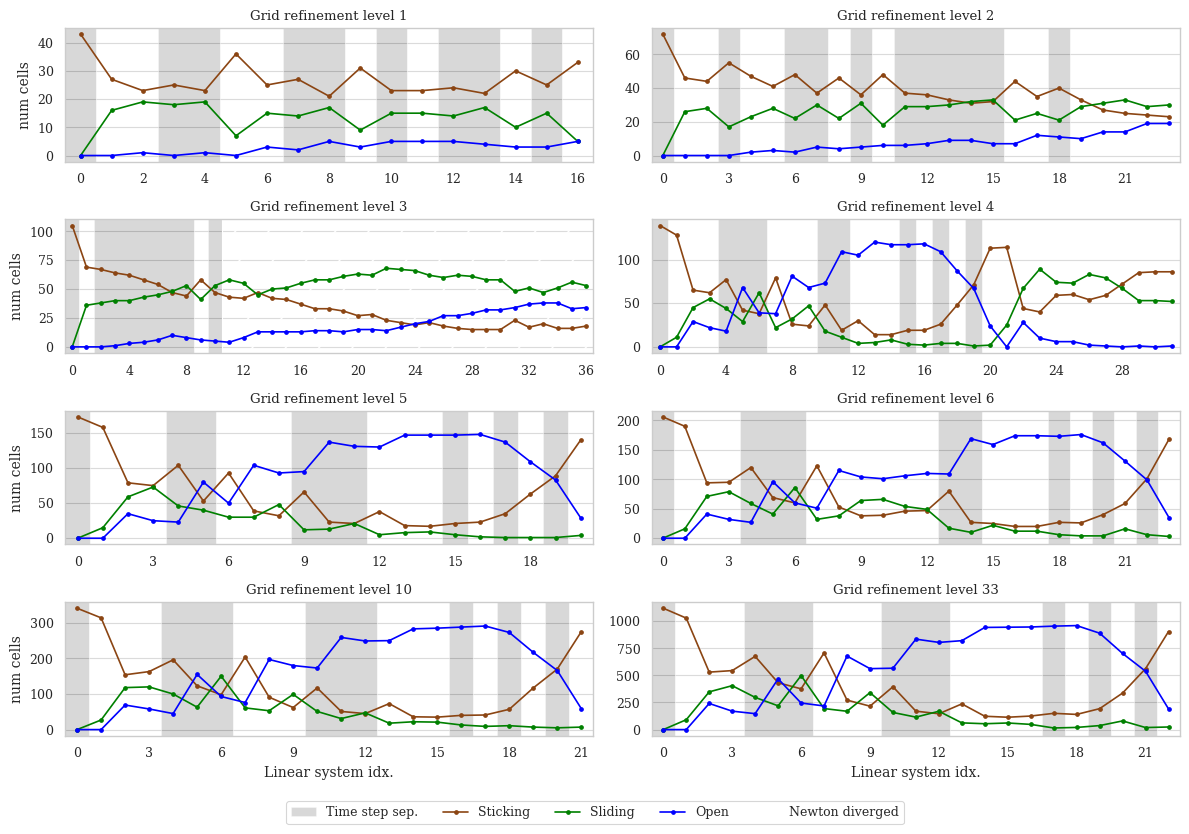

In [11]:
def render_element(i: int, entry: Sequence[TimeStepStats]):
    st, sl, op = get_num_sticking_sliding_open(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.gca().grid(False)
    plt.gca().grid(True, which="major", axis="y")
    plt.plot(st, label="Sticking", marker=".", color=COLOR_STICKING)
    plt.plot(sl, label="Sliding", marker=".", color=COLOR_SLIDING)
    plt.plot(op, label="Open", marker=".", color=COLOR_OPEN)
    # plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)


plot_grid(
    data,
    render_element,
    shape=shape,
    figsize=figsize,
    ylabel="num cells",
    ax_titles=names,
    #   ylabel="Fract. len., m"
)
# plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')

# Grid refinement

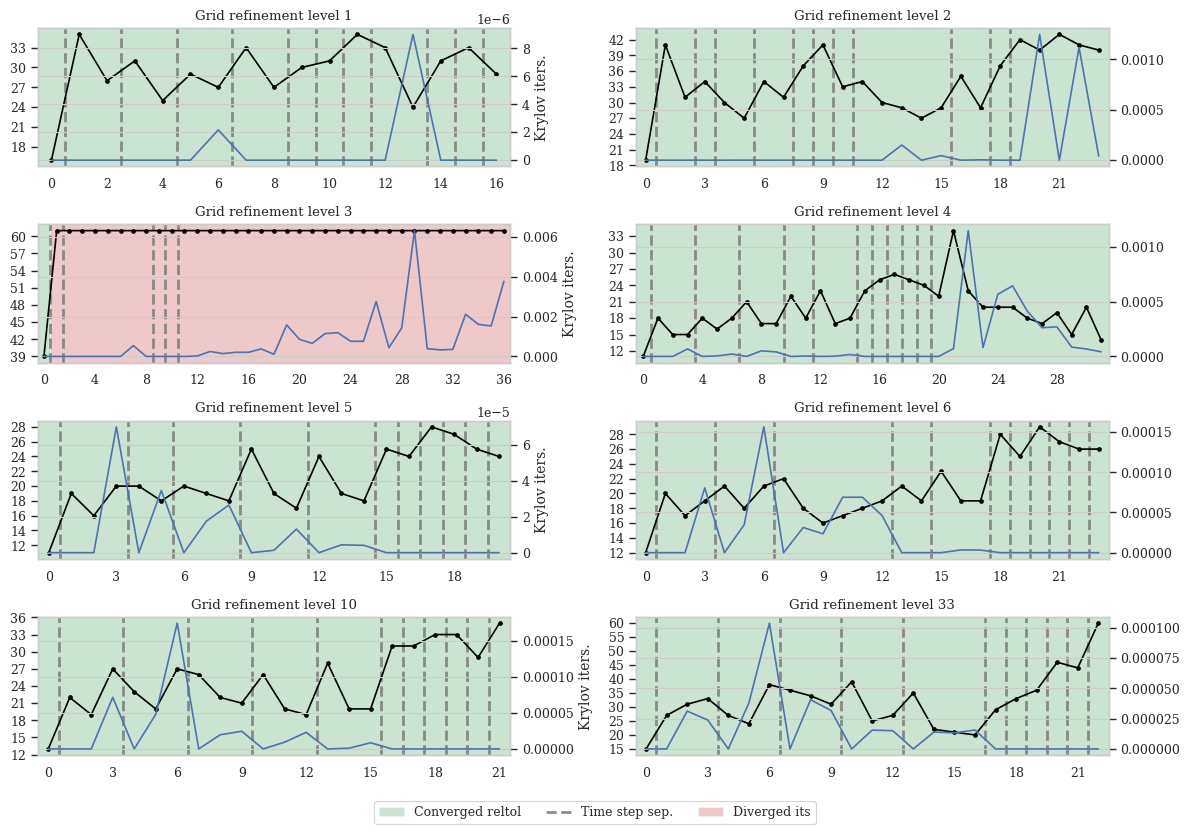

In [12]:
def render_element(entry: list[TimeStepStats]):
    color_converged_reason(entry)
    # color_sticking_sliding_open(entry)

    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    set_integer_ticks("vertical")
    plt.plot(get_gmres_iterations(entry), marker=".", color="black")

    coulomb_mismatch = [ls.coulomb_mismatch for ts in entry for ls in ts.linear_solves]
    sticking_ut = [ls.sticking_u_mismatch for ts in entry for ls in ts.linear_solves]
    lambdan_max = [ls.lambdan_max for ts in entry for ls in ts.linear_solves]
    lambdan_max[0] = 0
    lambdat_max = [ls.lambdat_max for ts in entry for ls in ts.linear_solves]
    ujumpn_max = [ls.un_max for ts in entry for ls in ts.linear_solves]
    ujumpt_max = [ls.ut_max for ts in entry for ls in ts.linear_solves]
    error_rotation = [ls.error_matrix_contribution for ts in entry for ls in ts.linear_solves]

    plt.gca().twinx()
    # plt.yscale('log')
    # plt.plot(coulomb_mismatch, label='Coulomb mismatch')  # interesting
    plt.plot(sticking_ut, label=r"Sticking $u_\tau$ mismatch")  # interesting
    # plt.plot(lambdan_max, label=r'$\lambda_n$ max')
    # plt.plot(lambdat_max, label=r'$\lambda_\tau$ max')
    # plt.plot(ujumpn_max, label=r"$u_n$ max")
    # plt.plot(ujumpt_max, label=r'$u_\tau$ max')
    # plt.plot(error_rotation, label="Error matrix contribution")  # interesting

    # plt.ylim(bottom=1e-6)


plot_grid(
    data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names
)

In [13]:
from collections import defaultdict
import pandas as pd

table = defaultdict(lambda: [])

NDIGITS = 2

grid_refinement = [1, 2, 3, 4, 6, 10, 33]

for g in grid_refinement:
    stats_name = f"stats_geo{geo}x{g}_sol{sol}_ph{ph}_bb{bb}_fr{fr}.json"
    entry = load_data(f"../stats/{stats_name}")
    dofs_info = load_data(f"../stats/dofs_info_{stats_name}")
    total_dofs = (
        dofs_info["block 0"]
        + dofs_info["block 1"]
        + dofs_info["block 2"]
        + dofs_info["block 3"]
        + dofs_info["block 4"]
        + dofs_info["block 5"]
    )
    table['tmp'] = '-'
    table["Total DoFs"].append(int(total_dofs))
    table["GMRES iters."].append(int(np.mean(get_gmres_iterations(entry))))
    table['Newton iters.'].append(round(np.mean(get_newton_iterations(entry)), NDIGITS))

    converged_reason = get_petsc_converged_reason(entry)
    # table['\# lim iters.'].append(sum(np.array(get_petsc_converged_reason(entry)) < 0))

table = pd.DataFrame(table).T[1:]
table.rename(columns=table.iloc[0], inplace=True)
table = table[1:]
table.columns.name = 'Total DoFs'
table

Total DoFs,2565,6921,14511,25002,53841,145596,1535409
GMRES iters.,29,33,60,19,20,24,31
Newton iters.,1.42,2.0,6.17,2.67,2.0,1.83,1.92


In [14]:
print(table.to_latex(float_format=f'%.{NDIGITS}f'))

\begin{tabular}{llllllll}
\toprule
Total DoFs & 2565 & 6921 & 14511 & 25002 & 53841 & 145596 & 1535409 \\
\midrule
GMRES iters. & 29 & 33 & 60 & 19 & 20 & 24 & 31 \\
Newton iters. & 1.42 & 2.00 & 6.17 & 2.67 & 2.00 & 1.83 & 1.92 \\
\bottomrule
\end{tabular}



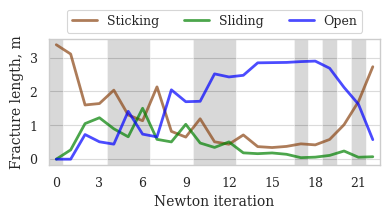

In [15]:
import latex_header

g = 33
stats_name = f"stats_geo{geo}x{g}_sol{sol}_ph{ph}_bb{bb}_fr{fr}.json"

plt.figure(figsize=(4, 2))
ALPHA = 0.7
LW = 2
MARKER = None

entry = load_data(f"../stats/{stats_name}")
st, sl, op = get_num_sticking_sliding_open(entry)
color_time_steps(entry, fill=True, grid=False, legend=False)

frac_len_mean = np.mean(load_data(f"../stats/dofs_info_{stats_name}")["cell_volumes"])

plt.gca().grid(False, axis="x")
# plt.gca().grid(True, which="major", axis="y")
plt.plot(
    np.array(st) * frac_len_mean,
    label="Sticking",
    marker=MARKER,
    color=COLOR_STICKING,
    alpha=ALPHA,
    linewidth=LW,
)
plt.plot(
    np.array(sl) * frac_len_mean,
    label="Sliding",
    marker=MARKER,
    color=COLOR_SLIDING,
    alpha=ALPHA,
    linewidth=LW,
)
plt.plot(
    np.array(op) * frac_len_mean,
    label="Open",
    marker=MARKER,
    color=COLOR_OPEN,
    alpha=ALPHA,
    linewidth=LW,
)

plt.xlabel("Newton iteration")
plt.ylabel("Fracture length, m")

plt.tight_layout()
lgd = plt.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=4,
    fancybox=True,
)


plt.savefig("tmp.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

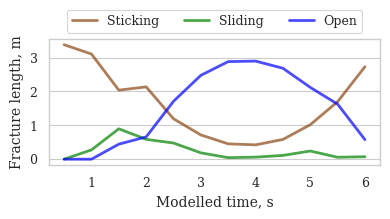

In [16]:
plt.figure(figsize=(4, 2))
ALPHA = 0.7
LW = 2
MARKER = None

entry = load_data(f"../stats/{stats_name}")
# st, sl, op = get_num_sticking_sliding_open(entry)
# color_time_steps(entry, fill=True, grid=False, legend=False)
st = [ts.linear_solves[0].num_sticking for ts in entry]
sl = [ts.linear_solves[0].num_sliding for ts in entry]
op = [ts.linear_solves[0].num_open for ts in entry]
time_steps = np.cumsum(get_time_steps(entry))


frac_len_mean = np.mean(load_data(f"../stats/dofs_info_{stats_name}")["cell_volumes"])

plt.gca().grid(False, axis="x")
# plt.gca().grid(True, which="major", axis="y")
plt.plot(
    time_steps,
    np.array(st) * frac_len_mean,
    label="Sticking",
    marker=MARKER,
    color=COLOR_STICKING,
    alpha=ALPHA,
    linewidth=LW,
)
plt.plot(
    time_steps,
    np.array(sl) * frac_len_mean,
    label="Sliding",
    marker=MARKER,
    color=COLOR_SLIDING,
    alpha=ALPHA,
    linewidth=LW,
)
plt.plot(
    time_steps,
    np.array(op) * frac_len_mean,
    label="Open",
    marker=MARKER,
    color=COLOR_OPEN,
    alpha=ALPHA,
    linewidth=LW,
)

plt.xlabel("Modelled time, s")
plt.ylabel("Fracture length, m")


plt.tight_layout()
lgd = plt.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=3,
    fancybox=True,
)


plt.savefig("tmp.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

* introduction
* num experiments
* conclusion
* Kundan works on section 3

* set domain to 1 km
* Direct subsolvers and Richardson, make fs fail